In [1]:
from math import sqrt

import matplotlib.pyplot as plt
import torch
from torchfem import Planar
from torchfem.elements import Quad1
from torchfem.materials import IsotropicPlaneStress

# Set plot to use TeX for rendering equations.
plt.rcParams["text.usetex"] = True
plt.rcParams["font.size"] = 14

torch.set_default_dtype(torch.double)

In [2]:
def get_cantilever(size, Lx, Ly, d=1.0, E=100, nu=0.3, etype=Quad1()):
    # Material
    material = IsotropicPlaneStress(E, nu)

    # Dimensions
    Nx = int(Lx / size)
    Ny = int(Ly / size)

    # Create nodes
    n1 = torch.linspace(0.0, Lx, Nx + 1)
    n2 = torch.linspace(0.0, Ly, Ny + 1)
    n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="xy"))
    nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

    # Create elements connecting nodes
    elements = []
    for j in range(Ny):
        for i in range(Nx):
            if isinstance(etype, Quad1):
                # Quad elements
                n0 = i + j * (Nx + 1)
                elements.append([n0, n0 + 1, n0 + Nx + 2, n0 + Nx + 1])
            else:
                # Tria elements
                n0 = i + j * (Nx + 1)
                elements.append([n0, n0 + 1, n0 + Nx + 2])
                elements.append([n0 + Nx + 2, n0 + Nx + 1, n0])
    elements = torch.tensor(elements)

    cantilever = Planar(nodes, elements, material)

    # Load at tip
    cantilever.forces[(int((Ny + 1) / 2) + 1) * (Nx + 1) - 1, 1] = -1.0

    # Constrained displacement at left end
    for i in range(Ny + 1):
        cantilever.constraints[i * (Nx + 1), :] = True

    # Default
    cantilever.thickness[:] = d

    return cantilever

## Define a 2D cantilever beam

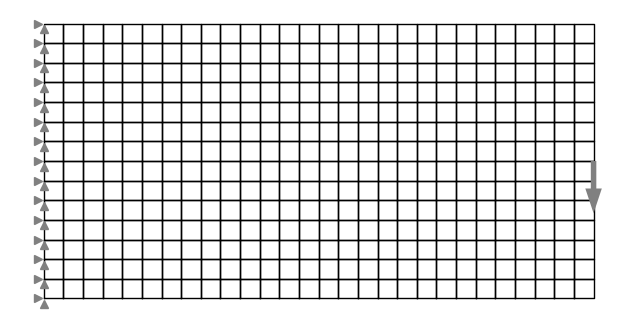

In [3]:
# Dimensions
cantilever = get_cantilever(1.0, 28.0, 14.0)
cantilever.plot()

## Optimization

In [4]:
def box_constrained_decent(func, x_init, x_lower, x_upper, eta=0.1, max_iter=100):
    x = x_init.clone().requires_grad_()
    for _ in range(max_iter):
        grad = torch.autograd.grad(func(x).sum(), x)[0]
        x = x - eta * grad
        x = torch.clamp(x, x_lower, x_upper)
    return x

In [5]:
def MMA(func, x_k, L_k, U_k):
    x_lin = x_k.clone().requires_grad_()
    grads = torch.autograd.grad(func(x_lin), x_lin)[0]
    neg_grad = grads < 0.0
    pos_grad = ~neg_grad
    f_k = func(x_k)

    def approximation(x):
        p = torch.zeros_like(grads)
        p[pos_grad] = (U_k[pos_grad] - x_k[pos_grad]) ** 2 * grads[pos_grad]
        q = torch.zeros_like(grads)
        q[neg_grad] = -((x_k[neg_grad] - L_k[neg_grad]) ** 2) * grads[neg_grad]
        return (
            f_k
            - torch.sum(p / (U_k - x_k) + q / (x_k - L_k))
            + torch.sum(p / (U_k - x) + q / (x - L_k))
        )

    return approximation, grads

In [6]:
def morph(fem, mask, phi, x):
    # Morph the mesh at masked positions with radial basis function
    nodes = torch.argwhere(mask)[:, 0]
    dirs = torch.argwhere(mask)[:, 1]
    M = phi[:, nodes]
    M = M[nodes, :]
    weights = torch.linalg.solve(M, x - fem.nodes[mask])
    for weight, node, dir in zip(weights, nodes, dirs):
        fem.nodes[:, dir] += weight * phi[node, :]

In [7]:
def compute_areas(truss):
    areas = torch.zeros((truss.n_elem))
    nodes = truss.nodes[truss.elements, :]
    for w, q in zip(truss.etype.iweights(), truss.etype.ipoints()):
        J = truss.etype.B(q) @ nodes
        detJ = torch.linalg.det(J)
        areas[:] += w * detJ
    return areas

In [8]:
def optimize(fem, x_0, x_min, x_max, V_0, mask, iter, morph_mesh=True):
    s = 0.7

    # Set up lists for L, U, x
    L = []
    U = []
    x = [x_0]

    # Define the initial value, lower bound, and upper bound of "mu"
    mu_0 = torch.tensor([0.01])
    mu_lower = torch.tensor([1e-10])
    mu_upper = torch.tensor([100.0])

    # Precompute radial basis functions for morphing
    epsilon = 0.1
    r = torch.cdist(cantilever.nodes, cantilever.nodes)
    phi = torch.exp(-((epsilon * r) ** 2))

    def f(x):
        # Update nodes
        if morph_mesh:
            morph(fem, mask, phi, x)
        else:
            fem.nodes[mask] = x.reshape(fem.nodes[mask].shape)
        # Solve fem with updated nodes
        u_k, f_k = fem.solve()
        # Return compliance
        return torch.inner(f_k.ravel(), u_k.ravel())

    def g(x):
        # Update nodes
        fem.nodes[mask] = x.reshape(fem.nodes[mask].shape)
        areas = compute_areas(fem)
        # Return constraint function
        return torch.inner(fem.thickness, areas) - V_0

    for k in range(iter):
        # Update asymptotes with heuristic procedure
        if k <= 1:
            L.append(x[k] - s * (x_max - x_min))
            U.append(x[k] + s * (x_max - x_min))
        else:
            L_k = torch.zeros_like(L[k - 1])
            U_k = torch.zeros_like(U[k - 1])
            # Shrink all oscillating asymptotes
            osci = (x[k] - x[k - 1]) * (x[k - 1] - x[k - 2]) < 0.0
            L_k[osci] = x[k][osci] - s * (x[k - 1][osci] - L[k - 1][osci])
            U_k[osci] = x[k][osci] + s * (U[k - 1][osci] - x[k - 1][osci])
            # Expand all non-oscillating asymptotes
            L_k[~osci] = x[k][~osci] - 1 / sqrt(s) * (x[k - 1][~osci] - L[k - 1][~osci])
            U_k[~osci] = x[k][~osci] + 1 / sqrt(s) * (U[k - 1][~osci] - x[k - 1][~osci])
            L.append(L_k)
            U.append(U_k)

        # Compute lower move limit in this step
        x_min_k = torch.max(x_min, 0.9 * L[k] + 0.1 * x[k])
        x_max_k = torch.min(x_max, 0.9 * U[k] + 0.1 * x[k])

        # Compute the current approximation function and save gradients
        f_tilde, f_grad = MMA(f, x[k], L[k], U[k])
        g_tilde, g_grad = MMA(g, x[k], L[k], U[k])

        # Define the Lagrangian
        def lagrangian(x, mu):
            return f_tilde(x) + mu * g_tilde(x)

        # Define x_star by minimizing the Lagrangian w. r. t. x analytically
        def x_star(mu):
            x_hat = torch.zeros_like(f_grad)
            # Case 1
            cond1 = (f_grad > 0.0) & (g_grad > 0.0)
            x_hat[cond1] = x_min[cond1]
            # Case 2
            cond2 = (f_grad < 0.0) & (g_grad < 0.0)
            x_hat[cond2] = x_max[cond2]
            # Case 3
            cond3 = (f_grad > 0.0) & (g_grad < 0.0)
            roots = torch.sqrt(
                (-mu * g_grad[cond3] * (x[k][cond3] - L[k][cond3]) ** 2)
                / (U[k][cond3] - x[k][cond3]) ** 2
                / f_grad[cond3]
            )
            x_hat[cond3] = (U[k][cond3] * roots + L[k][cond3]) / (1 + roots)
            # Case 4
            cond4 = (f_grad < 0.0) & (g_grad > 0.0)
            roots = torch.sqrt(
                (-mu * g_grad[cond4] * (U[k][cond4] - x[k][cond4]) ** 2)
                / (x[k][cond4] - L[k][cond4]) ** 2
                / f_grad[cond4]
            )
            x_hat[cond4] = (U[k][cond4] + L[k][cond4] * roots) / (1 + roots)
            return torch.clamp(x_hat, x_min_k, x_max_k)

        # Define (-1 times) the dual function
        def dual_function(mu):
            return -lagrangian(x_star(mu), mu)

        # Compute the maximum of the dual function
        mu_star = box_constrained_decent(
            dual_function, mu_0, mu_lower, mu_upper, eta=0.0001
        )

        # # Plot the dual function (just for debuging)
        # mu = torch.linspace(0.0, 0.1, 50)
        # dual = [-dual_function(m) for m in mu]
        # with torch.no_grad():
        #     plt.plot(mu, dual)
        #     plt.axvline(mu_star.item(), color="black")
        #     plt.title(f"Dual function in iteration {k}")
        #     plt.show()

        # Compute current optimal point with dual solution
        x.append(x_star(mu_star))

    return x

In [9]:
# Mask only vertical degrees of freedom of upper edge
mask = torch.zeros_like(cantilever.nodes, dtype=bool)
# mask[Ny * (Nx + 1) : (Ny + 1) * (Nx + 1), 1] = True
mask[1:29, 1] = True
control_nodes = torch.argwhere(mask)[:, 0]

# Limits on design variables
x_0 = cantilever.nodes[mask].ravel()
x_min = x_0 - 2.0
x_max = x_0 + 0.5

# Thickness, area and volume of elements
areas = compute_areas(cantilever)
V0 = torch.inner(areas, cantilever.thickness)

In [10]:
x_opt = optimize(cantilever, x_0, x_min, x_max, V0, mask, 10, morph_mesh=False)

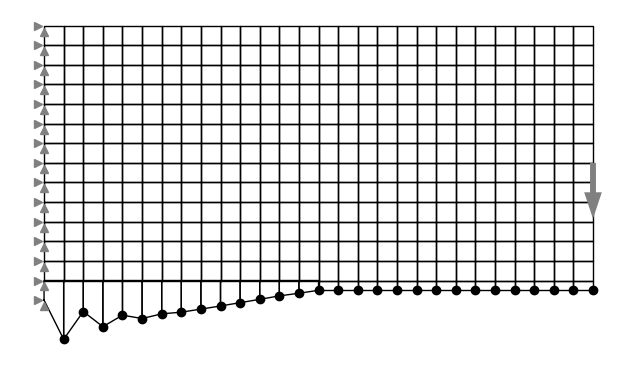

In [11]:
cantilever.plot()
plt.scatter(
    cantilever.nodes[control_nodes, 0].detach(),
    cantilever.nodes[control_nodes, 1].detach(),
    marker="o",
    color="black",
)
plt.savefig(
    "../figures/cantilever_fem_naive_shape.svg", transparent=True, bbox_inches="tight"
)

## Morphing

In [12]:
cantilever = get_cantilever(1.0, 28.0, 14.0)

mask = torch.zeros_like(cantilever.nodes, dtype=bool)
mask[0:29:7, 1] = True
mask[14 * 29 : 15 * 29 : 7, 1] = True
control_nodes = torch.argwhere(mask)[:, 0]

x_0 = cantilever.nodes[mask].ravel()
x_min = x_0 - 0.1
x_max = x_0 + 0.1
x_min[0:5] = x_0[0:5] - 5.0
x_max[0:5] = x_0[0:5] + 5.0

# Precompute radial basis functions for morphing
r = torch.cdist(cantilever.nodes, cantilever.nodes)
# phi = r
epsilon = 0.1
phi = torch.exp(-((epsilon * r) ** 2))

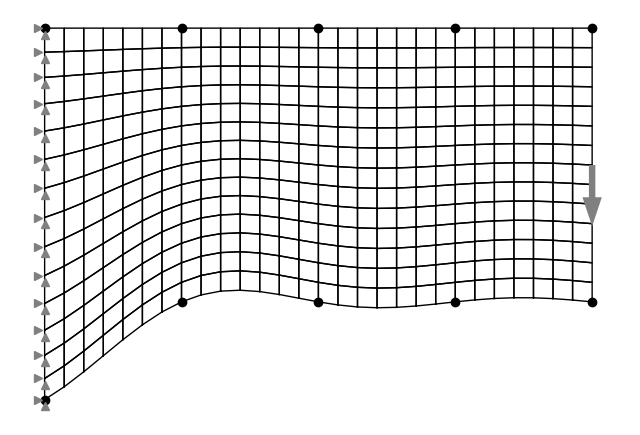

In [13]:
morph(
    cantilever,
    mask,
    phi,
    torch.tensor([-5.0, 0.0, 0.0, 0.0, 0.0, 14.0, 14.0, 14.0, 14.0, 14.0]),
)
cantilever.plot()
plt.scatter(
    cantilever.nodes[control_nodes, 0],
    cantilever.nodes[control_nodes, 1],
    marker="o",
    color="black",
)
plt.savefig(
    "../figures/cantilever_fem_shape_0.svg", transparent=True, bbox_inches="tight"
)

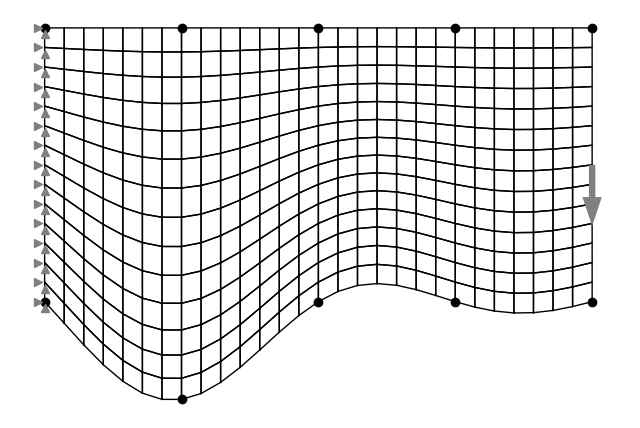

In [14]:
morph(
    cantilever,
    mask,
    phi,
    torch.tensor([0.0, -5.0, 0.0, 0.0, 0.0, 14.0, 14.0, 14.0, 14.0, 14.0]),
)
cantilever.plot()
plt.scatter(
    cantilever.nodes[control_nodes, 0],
    cantilever.nodes[control_nodes, 1],
    marker="o",
    color="black",
)
plt.savefig(
    "../figures/cantilever_fem_shape_1.svg", transparent=True, bbox_inches="tight"
)

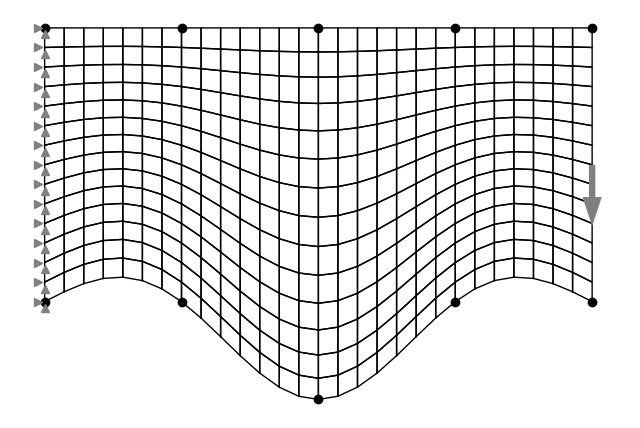

In [15]:
morph(
    cantilever,
    mask,
    phi,
    torch.tensor([0.0, 0.0, -5.0, 0.0, 0.0, 14.0, 14.0, 14.0, 14.0, 14.0]),
)
cantilever.plot()
plt.scatter(
    cantilever.nodes[control_nodes, 0],
    cantilever.nodes[control_nodes, 1],
    marker="o",
    color="black",
)
plt.savefig(
    "../figures/cantilever_fem_shape_2.svg", transparent=True, bbox_inches="tight"
)

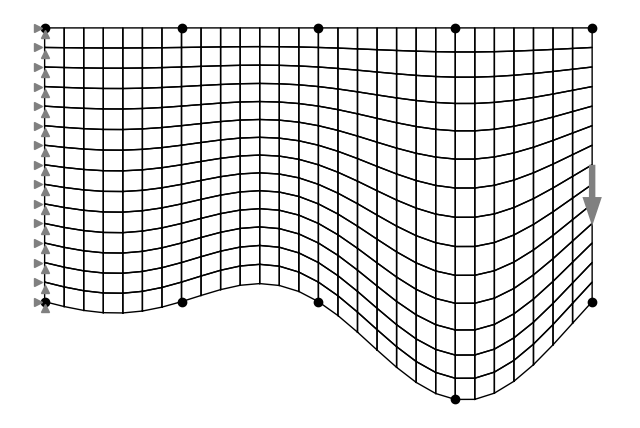

In [16]:
morph(
    cantilever,
    mask,
    phi,
    torch.tensor([0.0, 0.0, 0.0, -5.0, 0.0, 14.0, 14.0, 14.0, 14.0, 14.0]),
)
cantilever.plot()
plt.scatter(
    cantilever.nodes[control_nodes, 0],
    cantilever.nodes[control_nodes, 1],
    marker="o",
    color="black",
)
plt.savefig(
    "../figures/cantilever_fem_shape_3.svg", transparent=True, bbox_inches="tight"
)

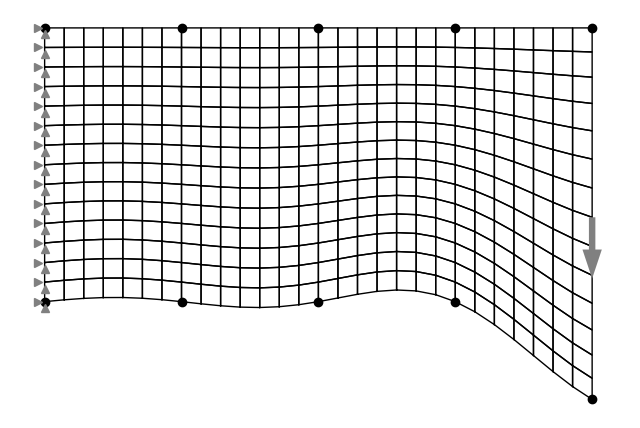

In [17]:
morph(
    cantilever,
    mask,
    phi,
    torch.tensor([0.0, 0.0, 0.0, 0.0, -5.0, 14.0, 14.0, 14.0, 14.0, 14.0]),
)
cantilever.plot()
plt.scatter(
    cantilever.nodes[control_nodes, 0],
    cantilever.nodes[control_nodes, 1],
    marker="o",
    color="black",
)
plt.savefig(
    "../figures/cantilever_fem_shape_4.svg", transparent=True, bbox_inches="tight"
)

In [18]:
morph(
    cantilever,
    mask,
    phi,
    torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 14.0, 14.0, 14.0, 14.0]),
)

In [19]:
x_opt = optimize(cantilever, x_0, x_min, x_max, V0, mask, 20, morph_mesh=True)

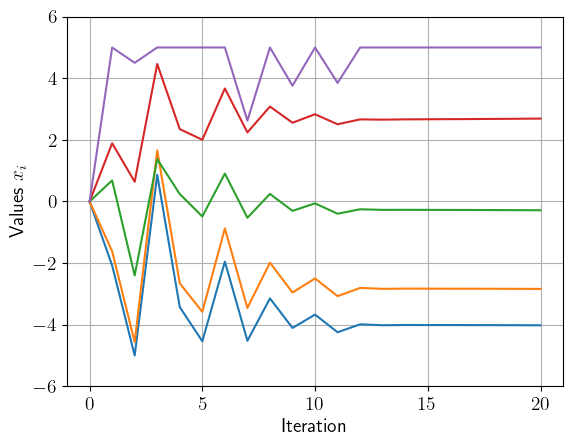

In [20]:
# Plot the development of design variables
plt.plot(torch.stack(x_opt).detach())
plt.xlabel("Iteration")
plt.ylabel("Values $x_i$")
plt.ylim([-6, 6.0])
plt.grid()
plt.savefig(
    "../figures/cantilever_fem_shape_variables.svg",
    transparent=True,
    bbox_inches="tight",
)

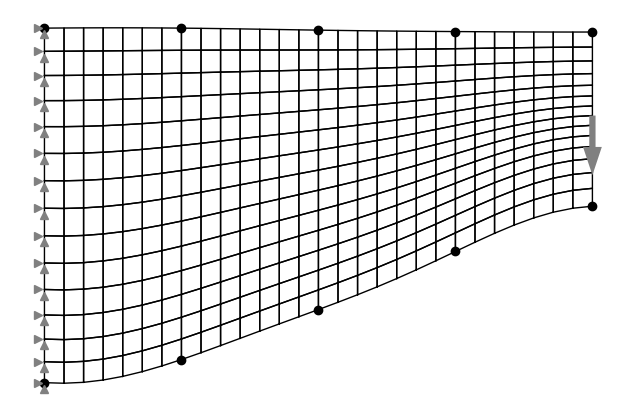

In [21]:
cantilever.plot()
plt.scatter(
    cantilever.nodes[control_nodes, 0].detach(),
    cantilever.nodes[control_nodes, 1].detach(),
    marker="o",
    color="black",
)
plt.savefig(
    "../figures/cantilever_fem_shape.svg", transparent=True, bbox_inches="tight"
)